In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample


#CreditCard Fraud Detection
##Improving Fraud Detection in Credit Card Transactions With Highly Imbalanced Data

###**Context:**
Accurate detection of fraudulent credit card transactions is crucial for protecting customers from unauthorized charges. In this project, I will explore a novel two-step upsampling strategy that combines **Variational Autoencoders**(VAE) and **Generative Adversarial Networks** (GAN) to improve the detection of fraudulent transactions. This VAE-GAN pipeline will be compared with traditional upsampling techniques like SMOTE to evaluate which method enhances fraud detection most effectively.

Fraud detection will be performed using two classifiers—Isolation Forests and Random Forests—to evaluate performance before and after upsampling.


###**Objective:**
We aim to detect fraudulent credit card transactions using various upsampling techniques such as SMOTE and VAE-GAN. We'll evaluate model performance using Isolation Forest and Random Forest classifiers, comparing their performance before and after balancing the dataset.

In this notebook we will:


*   Analyze and Visualize the Data
*   Perform Isolation and Random Forest ML Techniques
*   Compare Customized Upsampled and Smote upsampled Random Forest Accuracy



In [2]:
# Load the dataset
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/PortFolio/CreditCardFraud/creditcard.csv")

# Check for NaN values and data distribution
print(f"Amount of NaN values per column:\n{df.isnull().sum()[df.isnull().sum() > 0]}")
print(f"Distribution of fraud and non-fraud cases:\n{df['Class'].value_counts()}")


Mounted at /content/drive
Amount of NaN values per column:
Series([], dtype: int64)
Distribution of fraud and non-fraud cases:
Class
0    284315
1       492
Name: count, dtype: int64


**Observation:** The dataset is heavily imbalanced, with 492 fraud cases and 284,315 non-fraud cases. No missing values are present.

###Visualizing Class Imbalance
We use a bar plot to visually demonstrate the class imbalance in the dataset.

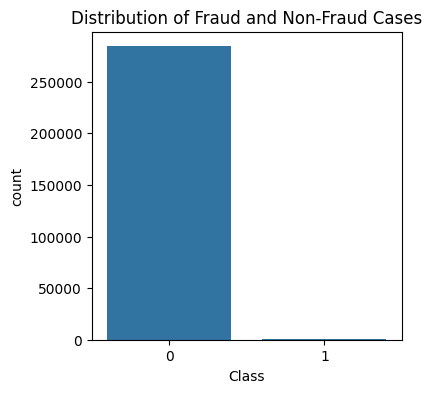

In [ ]:
# Visualize class imbalance
plt.figure(figsize=(4,4))
sns.countplot(x='Class', data=df)
plt.title('Distribution of Fraud and Non-Fraud Cases')
plt.show()


In [3]:
columns = df.columns.tolist()
# Making our Independent Features
columns = [var for var in columns if var not in ["Class"]]
# Making our Dependent Variable
target = "Class"
x= df[columns]
y= df[target]

###Baseline Model (Isolation Forest)
We now split the data into training and testing sets and evaluate the performance of an Isolation Forest model on the unbalanced dataset.

In [4]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

iso_forest= IsolationForest(n_estimators=10, max_samples=len(x_train),random_state=42, verbose=0)

iso_forest.fit(x_train,y_train)
baseline_fraud_predictions = iso_forest.predict(x_test)


baseline_fraud_predictions[baseline_fraud_predictions == 1] = 0
baseline_fraud_predictions[baseline_fraud_predictions== -1] = 1

baseline_fraud_predictions


array([1, 0, 0, ..., 0, 0, 0])

Baseline Accuracy: 0.9969453319757031
Baseline Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.22      0.37      0.28       136

    accuracy                           1.00     85443
   macro avg       0.61      0.68      0.64     85443
weighted avg       1.00      1.00      1.00     85443



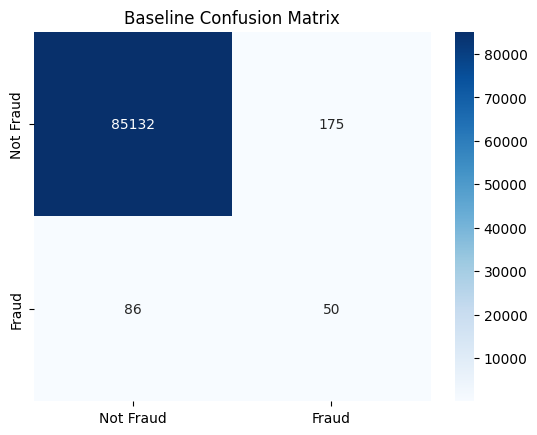

In [5]:
# Evaluate baseline model
print(f"Baseline Accuracy: {accuracy_score(y_test, baseline_fraud_predictions)}")
print(f"Baseline Classification Report:\n {classification_report(y_test, baseline_fraud_predictions)}")

# Confusion matrix for baseline
cm = confusion_matrix(y_test, baseline_fraud_predictions)
sns.heatmap(pd.DataFrame(cm, index=['Not Fraud', 'Fraud'], columns=['Not Fraud', 'Fraud']), annot=True, fmt='g', cmap="Blues")
plt.title('Baseline Confusion Matrix')
plt.show()


**Observation:** 115 cases of fraudulent transactions have been misclassified as non fraudulent while 57 were classified correctly. The scores for non-fraudulent data are misleading: With a probability of 99,87% of a transaction being non-fraudulant the model could classify all transactions as such and still achieve a 99,87% accuracy.

###Random Forest Classifier Comparison
Will the scores for detecting fraud improve after using SMOTE upsampling technique?

Random Forest Accuracy: 0.9995669627705019
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.94      0.78      0.85       136

    accuracy                           1.00     85443
   macro avg       0.97      0.89      0.93     85443
weighted avg       1.00      1.00      1.00     85443



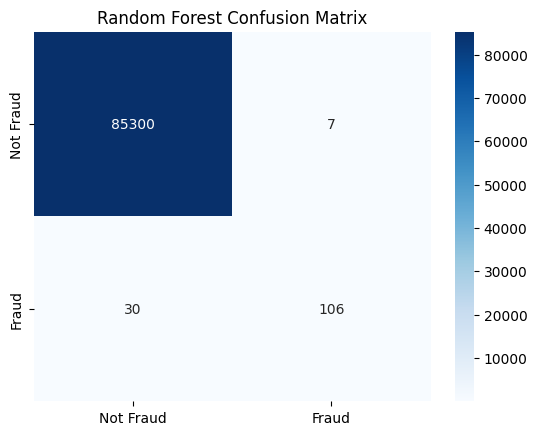

In [6]:
# Splitting the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

# Initialize the RandomForestClassifier also note: n_estimators is a tenth than that
#of the isolation forest due to time eficiancy.
rf_classifier = RandomForestClassifier(n_estimators=10, random_state=42)

# Train the model on the training data
rf_classifier.fit(x_train, y_train)

# Make predictions on the test data
rf_fraud_predictions = rf_classifier.predict(x_test)

# Evaluate the model
print(f"Random Forest Accuracy: {accuracy_score(y_test, rf_fraud_predictions)}")
print(f"Classification Report:\n {classification_report(y_test, rf_fraud_predictions)}")

# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, rf_fraud_predictions)
sns.heatmap(pd.DataFrame(cm_rf, index=['Not Fraud', 'Fraud'], columns=['Not Fraud', 'Fraud']), annot=True, fmt='g', cmap="Blues")
plt.title('Random Forest Confusion Matrix')
plt.show()


## Using custom found upsampling method.

Inspired by VAE, random samples can be drawn from a distribution. Assuming features follow that distribution and sampling from them (retrieving a random variable for each feature distribution) kan make the data seem the same as its sampled from the same probability of X given N(mu,sigma)

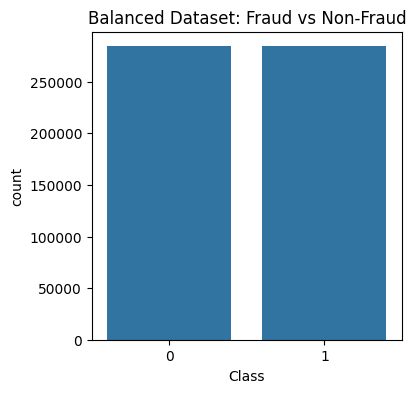

In [7]:
# Separate majority and minority classes before train-test split
minority_class = df[df['Class'] == 1]  # Fraudulent transactions (minority class)
majority_class = df[df['Class'] == 0]  # Non-fraudulent transactions (majority class)

# Compute the mean and variance for each feature in the minority class
means = minority_class.mean()
variances = minority_class.var()

# Number of synthetic samples to generate to balance the classes
num_synthetic_samples = len(majority_class) - len(minority_class)

# Generate synthetic samples by sampling from a normal distribution
synthetic_data = np.random.normal(loc=means, scale=np.sqrt(variances), size=(num_synthetic_samples, minority_class.shape[1]))

# Convert synthetic data to DataFrame and assign column names
synthetic_df = pd.DataFrame(synthetic_data, columns=minority_class.columns)

# Ensure the 'Class' column is set to 1 for the synthetic data (fraud)
synthetic_df['Class'] = 1

# Concatenate the original minority class and synthetic samples
upsampled_minority_class = pd.concat([minority_class, synthetic_df])

# Combine the upsampled minority class with the majority class to create a balanced dataset
balanced_df = pd.concat([majority_class, upsampled_minority_class])

# Check class distribution to confirm it's balanced
plt.figure(figsize=(4, 4))
sns.countplot(x='Class', data=balanced_df)
plt.title('Balanced Dataset: Fraud vs Non-Fraud')
plt.show()


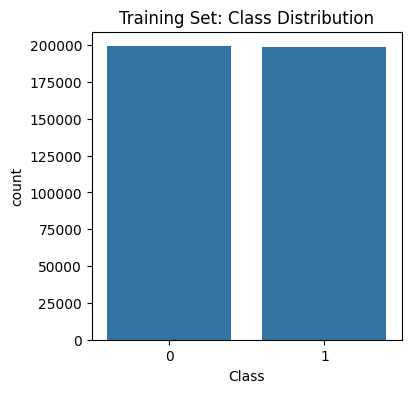

In [8]:
# Separate features and target
X = balanced_df.drop('Class', axis=1)  # Features only
y = balanced_df['Class']  # Target (Class column)

# Split the balanced data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Check the class distribution in the training set to ensure balance
plt.figure(figsize=(4, 4))
sns.countplot(x=y_train)
plt.title('Training Set: Class Distribution')
plt.show()

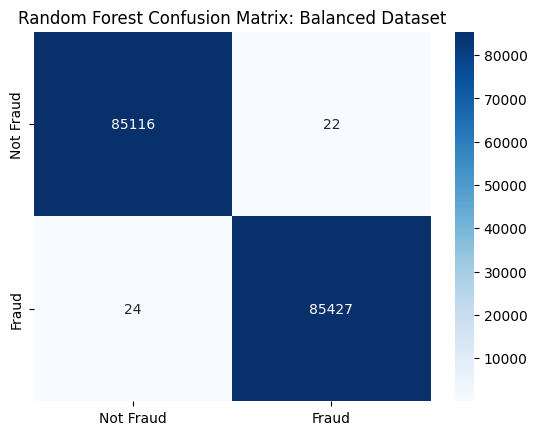

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85138
           1       1.00      1.00      1.00     85451

    accuracy                           1.00    170589
   macro avg       1.00      1.00      1.00    170589
weighted avg       1.00      1.00      1.00    170589



In [9]:
# Train a model (e.g., Random Forest)
clf = RandomForestClassifier(n_estimators=10, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred)
sns.heatmap(pd.DataFrame(cm_rf, index=['Not Fraud', 'Fraud'], columns=['Not Fraud', 'Fraud']), annot=True, fmt='g', cmap="Blues")
plt.title('Random Forest Confusion Matrix: Balanced Dataset')
plt.show()

# Classification report
print(classification_report(y_test, y_pred))


[[85280    27]
 [   18   118]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.81      0.87      0.84       136

    accuracy                           1.00     85443
   macro avg       0.91      0.93      0.92     85443
weighted avg       1.00      1.00      1.00     85443



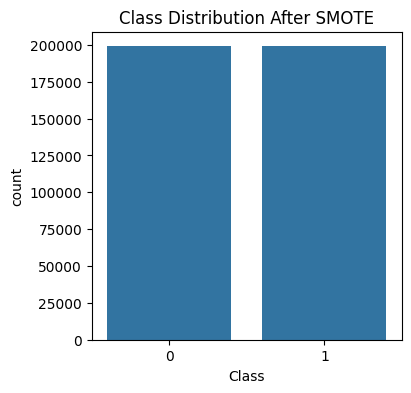

In [10]:
# Separate features and target
X = df.drop('Class', axis=1)
y = df['Class']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train a model using RandomForestClassifier (or any other model you like)
clf = RandomForestClassifier(n_estimators=10, random_state=42)
clf.fit(X_train_smote, y_train_smote)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Visualize class balance after SMOTE
plt.figure(figsize=(4,4))
sns.countplot(x=y_train_smote)
plt.title('Class Distribution After SMOTE')
plt.show()

##Cross Validating ensuring the model really outperforms.

In [ ]:

from sklearn.model_selection import cross_val_score

# Perform cross-validation
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print(f'Cross-Validation Scores: {scores}')
print(f'Mean Score: {np.mean(scores)}')

Cross-Validation Scores: [0.99973621 0.99962315 0.99977389 0.99969852 0.9995101 ]
Mean Score: 0.9996683757004051


#Evaluation
## Data Generation
**Customized Method**: Generating synthetic data based on the mean and variance of each feature, could work well if the minority class data distribution is simple and not too complex. This might create synthetic samples that are close to the majority of fraud cases, which could make it easier for the Random Forest to detect patterns in fraud.

**SMOTE:** SMOTE generates synthetic samples by interpolating between existing minority class samples, creating synthetic points along the line between nearest neighbors. If your fraud cases have complex or non-linear boundaries, SMOTE could produce synthetic points that lie too close to the boundary between fraud and non-fraud, potentially introducing noise.

##Model-Specific Performance
**Random Forest:** Random Forest works well with uncorrelated features and benefits from data that is somewhat normally distributed (like in your custom method). If your custom upsampling maintains feature relationships better, the model may find it easier to build good decision trees. SMOTE can sometimes generate synthetic points that introduce slight noise between features, which might confuse the model when building trees.

**SMOTE and Noise**: SMOTE may create points that are less representative of true fraud cases, especially if the minority class is small and spread out. The interpolated points might not reflect the true fraud patterns, leading to lower model performance.

##Feature Relationships

**Custom Method:** Might be maintaining the feature relationships more consistently because we're generating synthetic samples based on each feature independently. This could preserve certain patterns that Random Forest can exploit.

**SMOTE:** Because SMOTE generates synthetic points between neighbors, the relationships between features may become distorted. If the relationships between features in your dataset are critical to predicting fraud, SMOTE might introduce some noise.
